In [83]:
# Import curve fitting package from scipy
from scipy.optimize import curve_fit
import numpy as np
import matplotlib.pyplot as plt
import math
import numpy as np
from scipy.spatial import Delaunay
from scipy.interpolate import splprep
from scipy.interpolate import splev
import time

In [84]:
class Triangulacion():
    conos_exteriores = None
    conos_interiores = None
    def __init__(self, conos_interiores, conos_exteriores):
        self.internalNp = None
        self.interpolacion = None
        self.conos_exteriores = conos_exteriores
        self.conos_interiores = conos_interiores
        #self.conos_interiores = np.array([[o.point.x, o.point.y] for o in conos_interiores])
        #self.conos_exteriores = np.array([[o.point.x, o.point.y] for o in conos_exteriores])

        # TODO, ESTO ES PROVISIONAL, Precondición: La lista de conos ya viene ordenada
        #self.conos_exteriores = self.ordenar_respecto([0, 0], self.conos_exteriores)
        #self.conos_interiores = self.ordenar_respecto([0, 0], self.conos_interiores)
        self.conos_exteriores = np.array(self.conos_exteriores)
        self.conos_interiores = np.array(self.conos_interiores)

    def ordenar_respecto(self, coche, lista):
        return np.array(sorted(lista, key=lambda p: (p[0] - coche[0]) ** 2 + (p[1] - coche[1]) ** 2))

    def getEdges(self, triangle, edges, isEven):
        # t0 t1
        dist_min = 6
        flag = False
        if (isEven[0] + isEven[1] == 1):
            if (abs(triangle[0]-triangle[1]) < dist_min):
                edges[triangle[0], triangle[1]] = 1
                edges[triangle[1], triangle[0]] = 1
            else:
                flag = True
        # t0 t2
        if (isEven[0] + isEven[2] == 1):
            if (abs(triangle[0]-triangle[2]) < dist_min):
                edges[triangle[0], triangle[2]] = 1
                edges[triangle[2], triangle[0]] = 1
            else:
                flag = True
        # t1 t2
        if (isEven[1] + isEven[2] == 1):
            if (abs(triangle[2]-triangle[1]) < dist_min):
                edges[triangle[1], triangle[2]] = 1
                edges[triangle[2], triangle[1]] = 1
            else:
                flag = True
        return edges, flag

    def triangulacion(self):

        nci = len(self.conos_interiores)  # Numeros de conos interiores en la lista de conos
        col = 2
        nce = len(self.conos_exteriores)  # Numeros de conos exteriores en la lista de conos
        if (nci > 0 and nce > 0):

            maxConosLado = max(nci, nce)
            P = np.zeros((2 * maxConosLado, col))

            for i in range(0, maxConosLado):
                if (i >= nci):  # Solo quedan conos exteriores
                    P[i * 2] = self.conos_interiores[nci - 1]
                    P[i * 2 + 1] = self.conos_exteriores[i]
                elif (i >= nce):  # Solo quedan conos interiores
                    P[i * 2] = self.conos_interiores[i]
                    P[i * 2 + 1] = self.conos_exteriores[nce - 1]
                else:  # Quedan de los 2
                    P[i * 2] = self.conos_interiores[i]
                    P[i * 2 + 1] = self.conos_exteriores[i]

            internal = []
            # (12.939980506896973, 6.089759349822998) x
            # (3.0638973712921143, -1.9238924980163574) y
            xMaxI, yMaxI = self.conos_interiores.max(axis=0)
            xMinI, yMinI = self.conos_interiores.min(axis=0)

            xMaxE, yMaxE = self.conos_exteriores.max(axis=0)
            xMinE, yMinE = self.conos_exteriores.min(axis=0)

            xMax, yMax = max(xMaxI, xMaxE), max(yMaxI, yMaxE)
            xMin, yMin = min(xMinI, xMinE), min(yMinI, yMinE)

            # Posición del eje de dirección (No esta bien)
            dirX = 0.0
            dirY = 0.0

            #internal.append(np.array([dirX, dirY]))  # Para despues hacer la trayectoria desde el morro del coche
            # edgesMatrix = np.zeros([P.shape[0], P.shape[0]])
            edgesMatrix = np.zeros([maxConosLado * 2, maxConosLado * 2])

            # Crear triangulacion con constantes
            TR = Delaunay(P)

            s = TR.simplices
            i = 0
            while (i < s.shape[0]):

                x = s[i]
                isEven = x % 2
                if ((isEven[0] == 0 and isEven[1] == 0 and isEven[2] == 0) or (
                        isEven[0] == 1 and isEven[1] == 1 and isEven[2] == 1)):
                    s = np.delete(s, i, 0)
                else:
                    edgesMatrix, flag = self.getEdges(x, edgesMatrix, isEven)
                    if (flag):
                        s = np.delete(s, i, 0)
                    else:
                        i = i + 1
                    
            for fila in range(0, P.shape[0]):
                for columna in range(0, fila):
                    if (edgesMatrix[fila][columna] == 1):  # Es uno interno
                        p1 = P[fila]
                        p2 = P[columna]
                        internal.append(np.array([(p1[0] + p2[0]) / 2, (p1[1] + p2[1]) / 2]))                

            self.internalNp = np.array(internal)
            tck, u = splprep([self.internalNp[:, 0], self.internalNp[:, 1]], k=5, s=32)
            u = np.linspace(0, 1, num=100, endpoint=True)
            self.interpolacion = splev(u, tck)

            return self.internalNp, self.interpolacion, P, s, (xMax, xMin), (yMax, yMin)
        else:
            return None, None, None, None, None, None


In [102]:
class SimpleMiddlePath():
    conos_exteriores = None
    conos_interiores = None
    def __init__(self, conos_interiores, conos_exteriores):
        self.internalNp = None
        self.interpolacion = None
        self.conos_exteriores = conos_exteriores
        self.conos_interiores = conos_interiores
        #self.conos_interiores = np.array([[o.point.x, o.point.y] for o in conos_interiores])
        #self.conos_exteriores = np.array([[o.point.x, o.point.y] for o in conos_exteriores])

        # TODO, ESTO ES PROVISIONAL, Precondición: La lista de conos ya viene ordenada
        #self.conos_exteriores = self.ordenar_respecto([0, 0], self.conos_exteriores)
        #self.conos_interiores = self.ordenar_respecto([0, 0], self.conos_interiores)
        self.conos_exteriores = np.array(self.conos_exteriores)
        self.conos_interiores = np.array(self.conos_interiores)

    def ordenar_respecto(self, coche, lista):
        return np.array(sorted(lista, key=lambda p: (p[0] - coche[0]) ** 2 + (p[1] - coche[1]) ** 2))

    def planificacion(self):
        s = []
        nci = len(self.conos_interiores)  # Numeros de conos interiores en la lista de conos
        col = 2
        nce = len(self.conos_exteriores)  # Numeros de conos exteriores en la lista de conos
        if (nci > 0 and nce > 0):

            maxConosLado = max(nci, nce)
            P = np.zeros((2 * maxConosLado, col))

            for i in range(0, maxConosLado):
                if (i >= nci):  # Solo quedan conos exteriores
                    P[i * 2] = self.conos_interiores[nci - 1]
                    P[i * 2 + 1] = self.conos_exteriores[i]
                elif (i >= nce):  # Solo quedan conos interiores
                    P[i * 2] = self.conos_interiores[i]
                    P[i * 2 + 1] = self.conos_exteriores[nce - 1]
                else:  # Quedan de los 2
                    P[i * 2] = self.conos_interiores[i]
                    P[i * 2 + 1] = self.conos_exteriores[i]

            internal = []

            xMaxI, yMaxI = self.conos_interiores.max(axis=0)
            xMinI, yMinI = self.conos_interiores.min(axis=0)

            xMaxE, yMaxE = self.conos_exteriores.max(axis=0)
            xMinE, yMinE = self.conos_exteriores.min(axis=0)

            xMax, yMax = max(xMaxI, xMaxE), max(yMaxI, yMaxE)
            xMin, yMin = min(xMinI, xMinE), min(yMinI, yMinE)

            # Posición del eje de dirección (No esta bien)
            dirX = 0.0
            dirY = 0.0
            
            #internal.append(np.array([dirX, dirY]))  # Para despues hacer la trayectoria desde el morro del coche

    
                    
            cant_conos = max(nci, nce)
            for i in range(0, cant_conos-1):
        
                interior = P[2*i]
                exterior = P[2*i + 1]
                internal.append(np.array([(interior[0]+exterior[0])/2,(interior[1]+exterior[1])/2]))              
                s.append([2*i, 2*i+1])
                
            self.internalNp = np.array(internal)
            tck, u = splprep([self.internalNp[:, 0], self.internalNp[:, 1]], k=5, s=32)
            u = np.linspace(0, 1, num=100, endpoint=True)
            self.interpolacion = splev(u, tck)

            return self.internalNp, self.interpolacion, P, s, (xMax, xMin), (yMax, yMin)
        else:
            return None, None, None, None, None, None


In [103]:
def rectaI (x):
    return -1.5

In [104]:
def rectaE (x):
    return 1.5

In [105]:
def rectaM (x):
    return 0

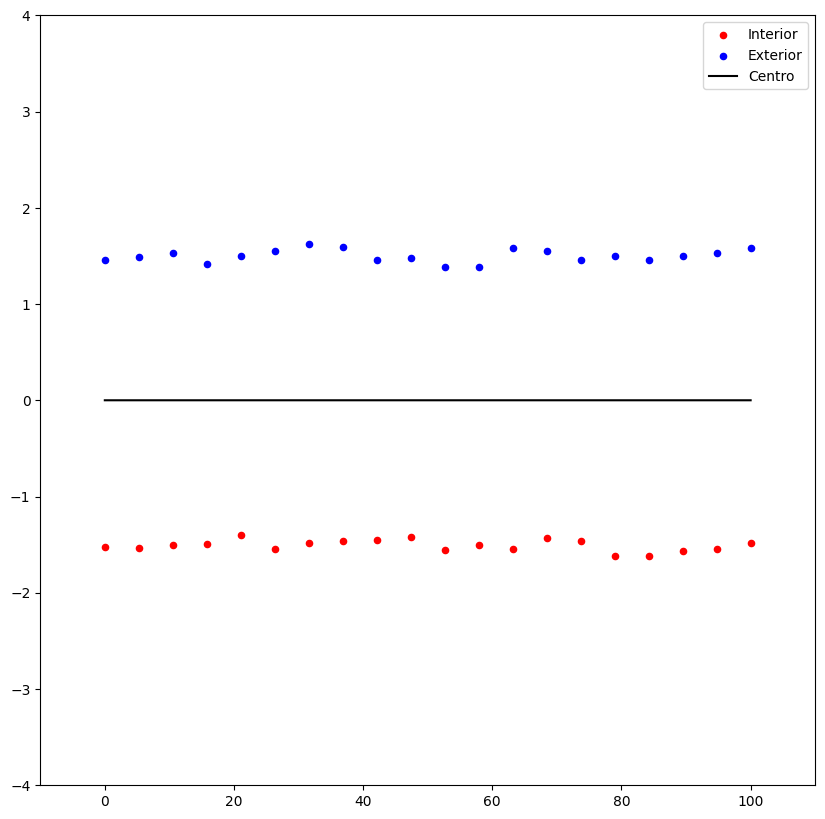

In [110]:
# Generate dummy dataset
num = 20
x_dummy_I = np.linspace(start=0, stop=100, num=num)

num = 20
x_dummy_E = np.linspace(start=0, stop=100, num=num)

num = 10000
x_dummy_M = np.linspace(start=0, stop=100, num=num)

num=20
# Calculate y-values based on dummy x-values
y_dummy_I = np.zeros([num])
for i in range(0,num):
    y_dummy_I[i] = rectaI(x_dummy_I[i])
# Add noise from a Gaussian distribution
noise = 0.05*np.random.normal(size=y_dummy_I.size)
y_dummy_I = y_dummy_I + noise


# Calculate y-values based on dummy x-values
y_dummy_E= np.zeros([num])
for i in range(0,num):
    y_dummy_E[i] = rectaE(x_dummy_E[i])
# Add noise from a Gaussian distribution
noise = 0.05*np.random.normal(size=y_dummy_E.size)
y_dummy_E = y_dummy_E + noise

num=10000
# Calculate y-values based on dummy x-values
y_dummy_M= np.zeros([num])
for i in range(0,num):
    y_dummy_M[i] = rectaM(x_dummy_M[i])
# Add noise from a Gaussian distribution
#noise = 0.1*np.random.normal(size=y_dummy_M.size)
#y_dummy_M = y_dummy_M + noise


# Plot the noisy exponential data
figure = plt.figure(figsize=(10, 10))
ax = figure.add_subplot(111)
ax.set_xlim([-10,110])
ax.set_ylim([-4,4])
plt.scatter(x_dummy_I, y_dummy_I, s=20, label='Interior', color='red')
plt.scatter(x_dummy_E, y_dummy_E, s=20, label='Exterior', color='blue')
plt.plot(x_dummy_M, y_dummy_M, label='Centro', color='black')
plt.legend()

MSE (Mean Square Error) = 0.0004899190790889626
RMSE (Root Mean Square Error) = 0.022134115728643027
Error Maximo = 0.03346876768427378 m

TIEMPO DE EJECUCIÓN DE LA TRIANGULACIÓN = 0.0020003318786621094 s


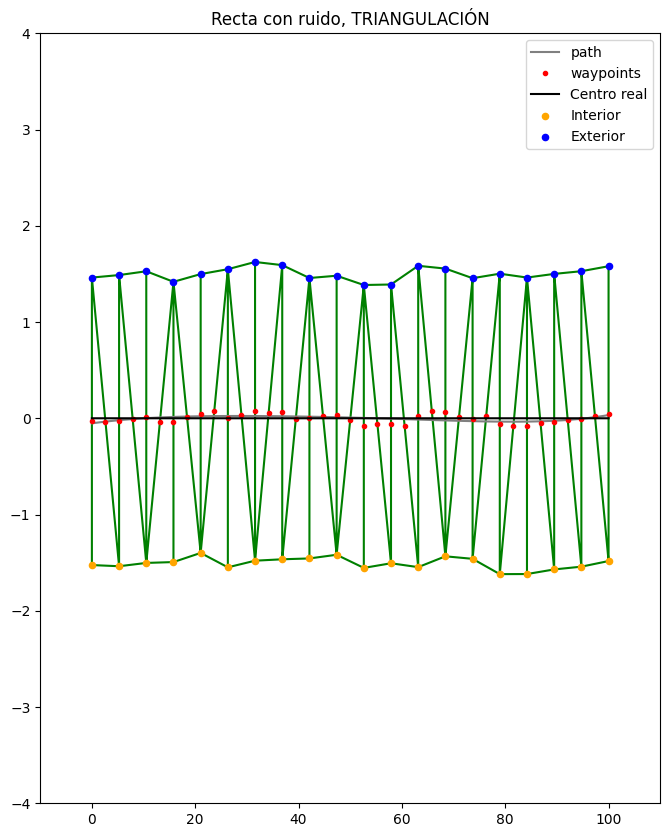

In [111]:
xI = np.array(x_dummy_I)
yI = np.array(y_dummy_I)
pI = np.array([xI,yI])
pI = np.transpose(pI)

xE = np.array(x_dummy_E)
yE = np.array(y_dummy_E)
pE = np.array([xE,yE])
pE = np.transpose(pE)

inicio = time.time()
triangulacion = Triangulacion(pI, pE)
waypoints, path, P, s, (xMax, xMin), (yMax, yMin) = triangulacion.triangulacion()
fin = time.time()
tiempo = fin-inicio

figure = plt.figure(figsize=(8, 10))
ax = figure.add_subplot(111)
ax.set_xlim([-10,110])
ax.set_ylim([-4,4])
plt.title('Recta con ruido, TRIANGULACIÓN')
plt.plot(path[0], path[1], color='grey', label='path')
plt.plot(waypoints[:,0], waypoints[:,1], '.', color='red', label='waypoints')
plt.triplot(P[:,0], P[:,1], s, color='green')
plt.plot(x_dummy_M, y_dummy_M, label='Centro real', color='black')
plt.scatter(x_dummy_I, y_dummy_I, s=20, label='Interior', color='orange')
plt.scatter(x_dummy_E, y_dummy_E, s=20, label='Exterior', color='blue')
plt.legend()

errores = []
for i in range (0, len(path[0])): 
    actX = path[0][i]
    actY = path[1][i]
    realY = rectaM(actX)
    errorAct = actY-realY
    errores.append(errorAct)

errores = np.array(errores)
errores_ponderados = errores**2
mse = sum(errores_ponderados)/len(errores)
rmse = math.sqrt(mse)
maxError = max(errores)
print('MSE (Mean Square Error) = '+str(mse))
print('RMSE (Root Mean Square Error) = '+str(rmse))
print('Error Maximo = '+str(maxError)+' m')
print('\nTIEMPO DE EJECUCIÓN DE LA TRIANGULACIÓN = '+str(tiempo)+' s')

MSE (Mean Square Error) = 0.0005231971105925151
RMSE (Root Mean Square Error) = 0.02287350236829758
Error Maximo = 0.026630811554757865 m

TIEMPO DE EJECUCIÓN DE LA PLANIFICACIÓN = 0.0010006427764892578 s


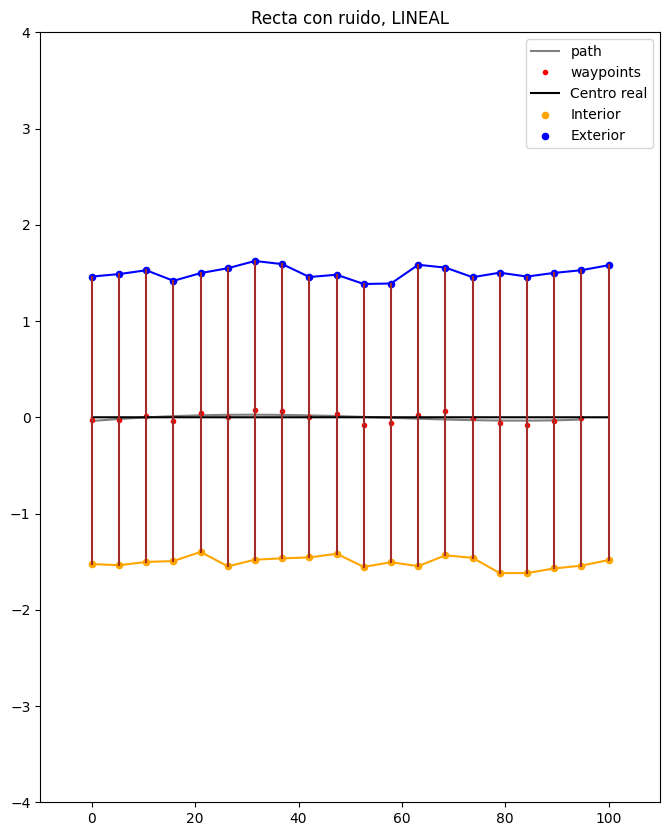

In [115]:
xI = np.array(x_dummy_I)
yI = np.array(y_dummy_I)
pI = np.array([xI,yI])
pI = np.transpose(pI)

xE = np.array(x_dummy_E)
yE = np.array(y_dummy_E)
pE = np.array([xE,yE])
pE = np.transpose(pE)

inicio = time.time()
middle_path = SimpleMiddlePath(pI, pE)
waypoints, path, P, s, (xMax, xMin), (yMax, yMin) = middle_path.planificacion()
fin = time.time()
tiempo = fin-inicio

figure = plt.figure(figsize=(8, 10))
ax = figure.add_subplot(111)
ax.set_xlim([-10,110])
ax.set_ylim([-4,4])
plt.title('Recta con ruido, LINEAL')
plt.plot(path[0], path[1], color='grey', label='path')
plt.plot(waypoints[:,0], waypoints[:,1], '.', color='red', label='waypoints')
plt.plot(x_dummy_M, y_dummy_M, label='Centro real', color='black')
plt.scatter(x_dummy_I, y_dummy_I, s=20, label='Interior', color='orange')
plt.plot(x_dummy_I, y_dummy_I, color='orange')
plt.scatter(x_dummy_E, y_dummy_E, s=20, label='Exterior', color='blue')
plt.plot(x_dummy_E, y_dummy_E, color='blue')
for i in range (0,P.shape[0],2):
    plt.plot([P[i, 0], P[i+1, 0]], [P[i, 1], P[i+1, 1]], color='brown')
    
plt.legend()

errores = []
for i in range (0, len(path[0])): 
    actX = path[0][i]
    actY = path[1][i]
    realY = rectaM(actX)
    errorAct = actY-realY
    errores.append(errorAct)

errores = np.array(errores)
errores_ponderados = errores**2
mse = sum(errores_ponderados)/len(errores)
rmse = math.sqrt(mse)
maxError = max(errores)
print('MSE (Mean Square Error) = '+str(mse))
print('RMSE (Root Mean Square Error) = '+str(rmse))
print('Error Maximo = '+str(maxError)+' m')
print('\nTIEMPO DE EJECUCIÓN DE LA PLANIFICACIÓN = '+str(tiempo)+' s')

In [132]:
def circleConstI (x):
    return math.sqrt(625-(x+26.5)**2), -math.sqrt(625-(x+26.5)**2)

In [133]:
def circleConstE (x):
    return math.sqrt(784-(x+26.5)**2), -math.sqrt(784-(x+26.5)**2)

In [134]:
def circleConstM (x):
    return math.sqrt(702.25-(x+26.5)**2), -math.sqrt(702.25-(x+26.5)**2)

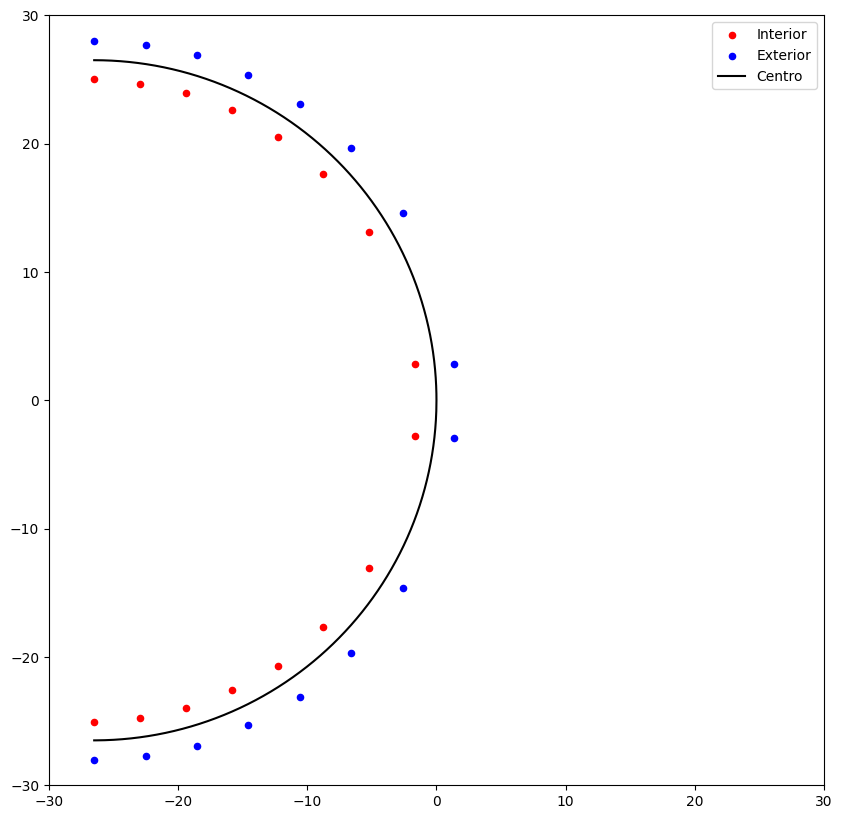

In [135]:
# Generate dummy dataset
num = 8
x_dummy_I = np.linspace(start=-26.5, stop=-1.65, num=num)
x_dummy_I = np.concatenate((x_dummy_I, x_dummy_I[::-1]))

num = 8
x_dummy_E = np.linspace(start=-26.5, stop=1.35, num=num)
x_dummy_E = np.concatenate((x_dummy_E, x_dummy_E[::-1]))

num = 10000
x_dummy_M = np.linspace(start=-26.5, stop=0, num=num)
x_dummy_M = np.concatenate((x_dummy_M, x_dummy_M[::-1]))

num=8
# Calculate y-values based on dummy x-values
y_dummy_I = np.zeros([num*2])
for i in range(0,num):
    y_dummy_I[i], y_dummy_I[num*2-1-i] = circleConstI(x_dummy_I[i])
# Add noise from a Gaussian distribution
noise = 0.05*np.random.normal(size=y_dummy_I.size)
y_dummy_I = y_dummy_I + noise


# Calculate y-values based on dummy x-values
y_dummy_E= np.zeros([num*2])
for i in range(0,num):
    y_dummy_E[i], y_dummy_E[num*2-1-i] = circleConstE(x_dummy_E[i])
# Add noise from a Gaussian distribution
noise = 0.05*np.random.normal(size=y_dummy_E.size)
y_dummy_E = y_dummy_E + noise

num=10000
# Calculate y-values based on dummy x-values
y_dummy_M= np.zeros([num*2])
for i in range(0,num):
    y_dummy_M[i], y_dummy_M[num*2-1-i] = circleConstM(x_dummy_M[i])
# Add noise from a Gaussian distribution
#noise = 0.1*np.random.normal(size=y_dummy_M.size)
#y_dummy_M = y_dummy_M + noise


# Plot the noisy exponential data
figure = plt.figure(figsize=(10, 10))
ax = figure.add_subplot(111)
ax.set_xlim([-30,30])
ax.set_ylim([-30,30])
plt.scatter(x_dummy_I, y_dummy_I, s=20, label='Interior', color='red')
plt.scatter(x_dummy_E, y_dummy_E, s=20, label='Exterior', color='blue')
plt.plot(x_dummy_M, y_dummy_M, label='Centro', color='black')
plt.legend()

MSE (Mean Square Error) = 0.6122688472278913
RMSE (Root Mean Square Error) = 0.7824761001001189
Error Maximo = 3.132535549601686 m


TIEMPO DE EJECUCIÓN DE LA TRIANGULACIÓN = 0.0019996166229248047 s


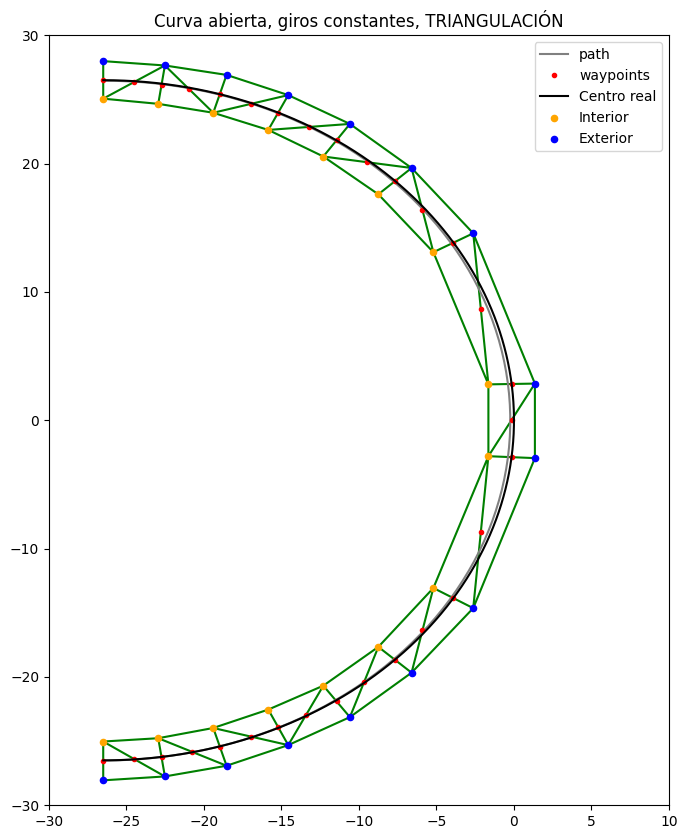

In [140]:
xI = np.array(x_dummy_I)
yI = np.array(y_dummy_I)
pI = np.array([xI,yI])
pI = np.transpose(pI)

xE = np.array(x_dummy_E)
yE = np.array(y_dummy_E)
pE = np.array([xE,yE])
pE = np.transpose(pE)

inicio = time.time()
triangulacion = Triangulacion(pI, pE)
waypoints, path, P, s, (xMax, xMin), (yMax, yMin) = triangulacion.triangulacion()
fin = time.time()
tiempo = fin-inicio

figure = plt.figure(figsize=(8, 10))
ax = figure.add_subplot(111)
ax.set_xlim([-30,10])
ax.set_ylim([-30,30])
plt.title('Curva abierta, giros constantes, TRIANGULACIÓN')
plt.plot(path[0], path[1], color='grey', label='path')
plt.plot(waypoints[:,0], waypoints[:,1], '.', color='red', label='waypoints')
plt.triplot(P[:,0], P[:,1], s, color='green')
plt.plot(x_dummy_M, y_dummy_M, label='Centro real', color='black')
plt.scatter(x_dummy_I, y_dummy_I, s=20, label='Interior', color='orange')
plt.scatter(x_dummy_E, y_dummy_E, s=20, label='Exterior', color='blue')
plt.legend()

errores = []
count = int(len(path[0])/2)
for i in range (0, len(path[0])): 
    actX = path[0][i]
    actY = path[1][i]
    if (i<count): # Mitad arriba
        realY, falseY = circleConstM(actX)
    else: # Mitad abajo
        falseY, realY = circleConstM(actX)

    errorAct = actY-realY
    errores.append(errorAct)

errores = np.array(errores)
errores_ponderados = errores**2
mse = sum(errores_ponderados)/len(errores)
rmse = math.sqrt(mse)
maxError = max(errores)
print('MSE (Mean Square Error) = '+str(mse))
print('RMSE (Root Mean Square Error) = '+str(rmse))
print('Error Maximo = '+str(maxError)+' m')
print()
print('\nTIEMPO DE EJECUCIÓN DE LA TRIANGULACIÓN = '+str(tiempo)+' s')

MSE (Mean Square Error) = 0.16529856174199511
RMSE (Root Mean Square Error) = 0.40656925823529144
Error Maximo = 3.3409284743820438 m

TIEMPO DE EJECUCIÓN DE LA TRIANGULACIÓN = 0.0010004043579101562 s


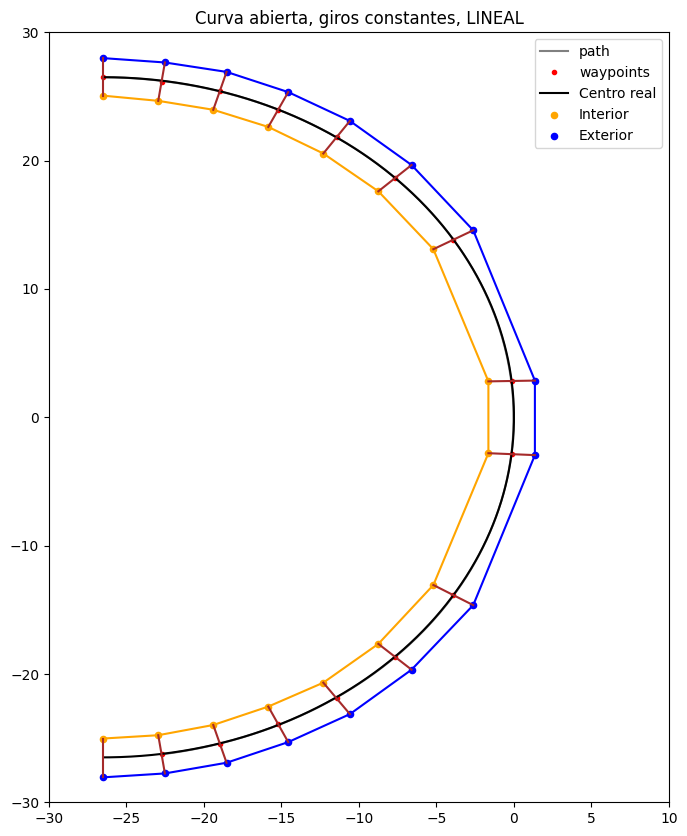

In [142]:
xI = np.array(x_dummy_I)
yI = np.array(y_dummy_I)
pI = np.array([xI,yI])
pI = np.transpose(pI)

xE = np.array(x_dummy_E)
yE = np.array(y_dummy_E)
pE = np.array([xE,yE])
pE = np.transpose(pE)

inicio = time.time()
middle_path = SimpleMiddlePath(pI, pE)
waypoints, path, P, s, (xMax, xMin), (yMax, yMin) = middle_path.planificacion()
fin = time.time()
tiempo = fin-inicio

figure = plt.figure(figsize=(8, 10))
ax = figure.add_subplot(111)
ax.set_xlim([-30,10])
ax.set_ylim([-30,30])
plt.title('Curva abierta, giros constantes, LINEAL')
plt.plot(path[0], path[1], color='grey', label='path')
plt.plot(waypoints[:,0], waypoints[:,1], '.', color='red', label='waypoints')
plt.plot(x_dummy_M, y_dummy_M, label='Centro real', color='black')
plt.scatter(x_dummy_I, y_dummy_I, s=20, label='Interior', color='orange')
plt.scatter(x_dummy_E, y_dummy_E, s=20, label='Exterior', color='blue')
plt.plot(x_dummy_I, y_dummy_I, color='orange')
plt.plot(x_dummy_E, y_dummy_E, color='blue')
for i in range (0,P.shape[0],2):
    plt.plot([P[i, 0], P[i+1, 0]], [P[i, 1], P[i+1, 1]], color='brown')
plt.legend()

errores = []
count = int(len(path[0])/2)
for i in range (0, len(path[0])): 
    actX = path[0][i]
    actY = path[1][i]
    if (i<count): # Mitad arriba
        realY, falseY = circleConstM(actX)
    else: # Mitad abajo
        falseY, realY = circleConstM(actX)

    errorAct = actY-realY
    errores.append(errorAct)

errores = np.array(errores)
errores_ponderados = errores**2
mse = sum(errores_ponderados)/len(errores)
rmse = math.sqrt(mse)
maxError = max(errores)
print('MSE (Mean Square Error) = '+str(mse))
print('RMSE (Root Mean Square Error) = '+str(rmse))
print('Error Maximo = '+str(maxError)+' m')
print('\nTIEMPO DE EJECUCIÓN DE LA TRIANGULACIÓN = '+str(tiempo)+' s')

In [143]:
def circleHorI (x):
    return math.sqrt(20.25-(x+6)**2), -math.sqrt(20.25-(x+6)**2)

In [144]:
def circleHorE (x):
    return math.sqrt(56.25-(x+6)**2), -math.sqrt(56.25-(x+6)**2)

In [145]:
def circleHorM (x):
    return math.sqrt(36-(x+6)**2), -math.sqrt(36-(x+6)**2)

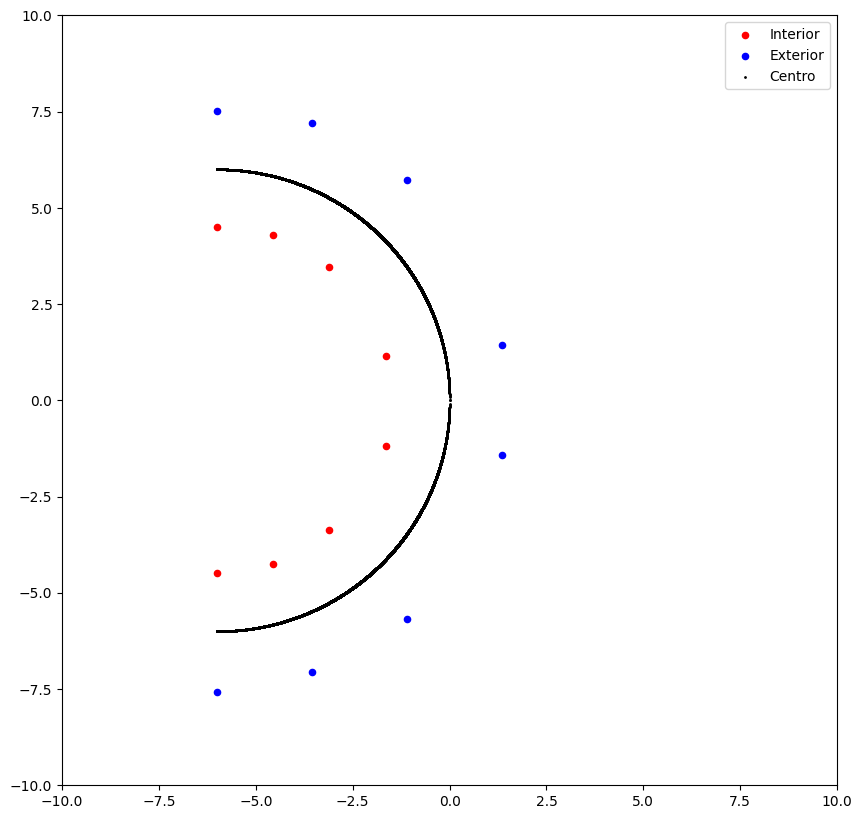

In [146]:
# Generate dummy dataset
num = 4
x_dummy_I = np.linspace(start=-6, stop=-1.65, num=num)
x_dummy_I = np.concatenate((x_dummy_I, x_dummy_I[::-1]))

num = 4
x_dummy_E = np.linspace(start=-6, stop=1.35, num=num)
x_dummy_E = np.concatenate((x_dummy_E, x_dummy_E[::-1]))

num = 10000
x_dummy_M = np.linspace(start=-6, stop=0, num=num)
x_dummy_M = np.concatenate((x_dummy_M, x_dummy_M[::-1]))

num=4
# Calculate y-values based on dummy x-values
y_dummy_I = np.zeros([num*2])
for i in range(0,num):
    y_dummy_I[i], y_dummy_I[num*2-1-i] = circleHorI(x_dummy_I[i])
# Add noise from a Gaussian distribution
noise = 0.05*np.random.normal(size=y_dummy_I.size)
y_dummy_I = y_dummy_I + noise


# Calculate y-values based on dummy x-values
y_dummy_E= np.zeros([num*2])
for i in range(0,num):
    y_dummy_E[i], y_dummy_E[num*2-1-i] = circleHorE(x_dummy_E[i])
# Add noise from a Gaussian distribution
noise = 0.05*np.random.normal(size=y_dummy_E.size)
y_dummy_E = y_dummy_E + noise

num=10000
# Calculate y-values based on dummy x-values
y_dummy_M= np.zeros([num*2])
for i in range(0,num):
    y_dummy_M[i], y_dummy_M[num*2-1-i] = circleHorM(x_dummy_M[i])
# Add noise from a Gaussian distribution
#noise = 0.1*np.random.normal(size=y_dummy_M.size)
#y_dummy_M = y_dummy_M + noise


# Plot the noisy exponential data
figure = plt.figure(figsize=(10, 10))
ax = figure.add_subplot(111)
ax.set_xlim([-10,10])
ax.set_ylim([-10,10])
plt.scatter(x_dummy_I, y_dummy_I, s=20, label='Interior', color='red')
plt.scatter(x_dummy_E, y_dummy_E, s=20, label='Exterior', color='blue')
plt.scatter(x_dummy_M, y_dummy_M, s=1, label='Centro', color='black')

plt.legend()



MSE (Mean Square Error) = 40.9021958335569
RMSE (Root Mean Square Error) = 6.39548245510508
Error Maximo = 10.76503044190267 m


TIEMPO DE EJECUCIÓN DE LA TRIANGULACIÓN = 0.0010004043579101562 s


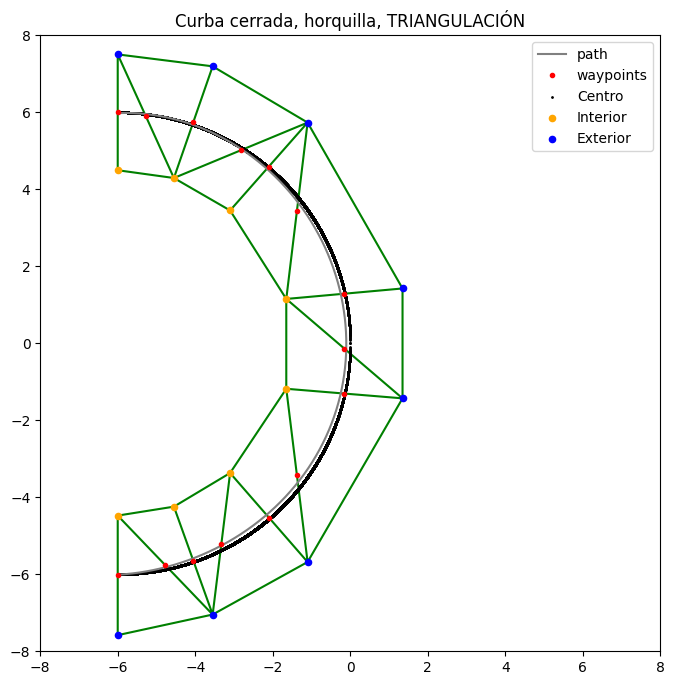

In [149]:
xI = np.array(x_dummy_I)
yI = np.array(y_dummy_I)
pI = np.array([xI,yI])
pI = np.transpose(pI)

xE = np.array(x_dummy_E)
yE = np.array(y_dummy_E)
pE = np.array([xE,yE])
pE = np.transpose(pE)


triangulacion = Triangulacion(pI, pE)
waypoints, path, P, s, (xMax, xMin), (yMax, yMin) = triangulacion.triangulacion()

figure = plt.figure(figsize=(8, 8))
ax = figure.add_subplot(111)
ax.set_xlim([-8,8])
ax.set_ylim([-8,8])
plt.title('Curba cerrada, horquilla, TRIANGULACIÓN')
plt.plot(path[0], path[1], color='grey', label='path')
plt.plot(waypoints[:,0], waypoints[:,1], '.', color='red', label='waypoints')
plt.triplot(P[:,0], P[:,1], s, color='green')
plt.scatter(x_dummy_M, y_dummy_M, s=1, label='Centro', color='black')
plt.scatter(x_dummy_I, y_dummy_I, s=20, label='Interior', color='orange')
plt.scatter(x_dummy_E, y_dummy_E, s=20, label='Exterior', color='blue')
plt.legend()

errores = []
count = int(len(path[0])/2)
for i in range (0, len(path[0])): 
    actX = path[0][i]
    actY = path[1][i]
    if (i<count): # Mitad arriba
        realY, falseY = circleConstM(actX)
    else: # Mitad abajo
        falseY, realY = circleConstM(actX)
    
    errorAct = actY-realY
    errores.append(errorAct)

errores = np.array(errores)
errores_ponderados = errores**2
mse = sum(errores_ponderados)/len(errores)
rmse = math.sqrt(mse)
maxError = max(errores)
print('MSE (Mean Square Error) = '+str(mse))
print('RMSE (Root Mean Square Error) = '+str(rmse))
print('Error Maximo = '+str(maxError)+' m')
print()
print('\nTIEMPO DE EJECUCIÓN DE LA TRIANGULACIÓN = '+str(tiempo)+' s')

MSE (Mean Square Error) = 32.19705684046901
RMSE (Root Mean Square Error) = 5.674245045860199
Error Maximo = 8.435166220133848 m

TIEMPO DE EJECUCIÓN DE LA TRIANGULACIÓN = 0.0010004043579101562 s


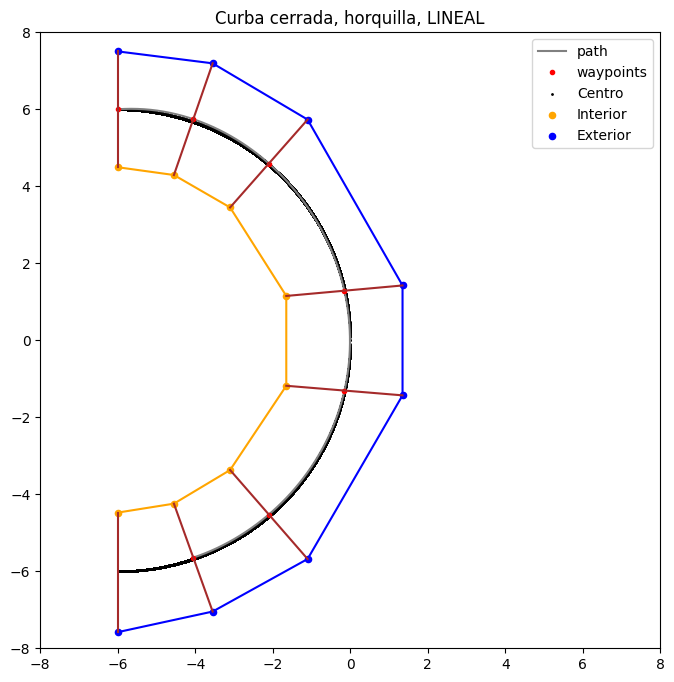

In [155]:
xI = np.array(x_dummy_I)
yI = np.array(y_dummy_I)
pI = np.array([xI,yI])
pI = np.transpose(pI)

xE = np.array(x_dummy_E)
yE = np.array(y_dummy_E)
pE = np.array([xE,yE])
pE = np.transpose(pE)


middle_path = SimpleMiddlePath(pI, pE)
waypoints, path, P, s, (xMax, xMin), (yMax, yMin) = middle_path.planificacion()

figure = plt.figure(figsize=(8, 8))
ax = figure.add_subplot(111)
ax.set_xlim([-8,8])
ax.set_ylim([-8,8])
plt.title('Curba cerrada, horquilla, LINEAL')
plt.plot(path[0], path[1], color='grey', label='path')
plt.plot(waypoints[:,0], waypoints[:,1], '.', color='red', label='waypoints')
plt.scatter(x_dummy_M, y_dummy_M, s=1, label='Centro', color='black')
plt.scatter(x_dummy_I, y_dummy_I, s=20, label='Interior', color='orange')
plt.scatter(x_dummy_E, y_dummy_E, s=20, label='Exterior', color='blue')
plt.plot(x_dummy_I, y_dummy_I, color='orange')
plt.plot(x_dummy_E, y_dummy_E, color='blue')
for i in range (0,P.shape[0],2):
    plt.plot([P[i, 0], P[i+1, 0]], [P[i, 1], P[i+1, 1]], color='brown')
    
plt.legend()

errores = []
count = int(len(path[0])/2)
for i in range (0, len(path[0])): 
    actX = path[0][i]
    actY = path[1][i]
    if (i<count): # Mitad arriba
        realY, falseY = circleConstM(actX)
    else: # Mitad abajo
        falseY, realY = circleConstM(actX)

    errorAct = actY-realY
    errores.append(errorAct)

errores = np.array(errores)
errores_ponderados = errores**2
mse = sum(errores_ponderados)/len(errores)
rmse = math.sqrt(mse)
maxError = max(errores)
print('MSE (Mean Square Error) = '+str(mse))
print('RMSE (Root Mean Square Error) = '+str(rmse))
print('Error Maximo = '+str(maxError)+' m')
print('\nTIEMPO DE EJECUCIÓN DE LA TRIANGULACIÓN = '+str(tiempo)+' s')